In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A

# pretrained models
import torchvision
from torchvision import models, transforms

In [53]:
np.array([[1, 0], [0,1]]), np.array([[1],[2]])

(array([[1, 0],
        [0, 1]]),
 array([[1],
        [2]]))

Image Data from [here](https://www.kaggle.com/andrewmvd/animal-faces)
- Animal Faces

## Resizing

In [2]:
# create a dataframe for our image data
data_path = 'course_data/afhq'

rows = []
for dataset in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{dataset}'):
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label
            row['dataset'] = dataset
        
            # a bit redudant, could build from other data in __getitem__ if wanted
            row['image_path'] = data_path + f'/{dataset}' + f'/{label}'
            rows.append(row)
        
df = pd.DataFrame(rows)
print(len(df))
df.head()

16130


,image_file,label,dataset,image_path
0,pixabay_cat_000455.jpg,cat,train,course_data/afhq/train/cat
1,pixabay_cat_001993.jpg,cat,train,course_data/afhq/train/cat
2,pixabay_cat_004633.jpg,cat,train,course_data/afhq/train/cat
3,pixabay_cat_002242.jpg,cat,train,course_data/afhq/train/cat
4,pixabay_cat_002524.jpg,cat,train,course_data/afhq/train/cat


In [3]:
# training and validation data
df_train = df[df['dataset'] == 'train'].reset_index(drop=True)
df_val = df[df['dataset'] == 'val'].reset_index(drop=True)
len(df_train), len(df_val)

(14630, 1500)

We're going to work with a pre-trained model that takes in images of size 224x224. We will reduce the resolution as a *pre-processings* step rather than on the fly to save time during training.
- Notice the time we save during each epoch: 3 seconds for me

In [4]:
def resize_img(path, size):
    img = cv2.imread(path)
    
    start = time.time()
    img = cv2.resize(img, size)
    end = time.time()
    
    cv2.imwrite(path, img)
    return end - start

# resize all of the images to 256x256
total_time_resize = 0.0
for idx in tqdm(range(len(df_train))):
    row = df_train.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))
    
for idx in tqdm(range(len(df_val))):
    row = df_train.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))
    

  0%|          | 0/14630 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
total_time_resize

0.006149768829345703

In [6]:
row = df_train.iloc[100]
image_path = row['image_path']
fname = row['image_file']
path = image_path+'/'+fname
img = cv2.imread(path)

img.shape

(256, 256, 3)

## Data Augmentation with [Albumentations](https://github.com/albumentations-team/albumentations)
- A suite of very fast transformations for images
- Supports masks and keypoints!

In [7]:
from albumentations.pytorch import ToTensorV2

# let's add an augmentation option
class AnimalFacesDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment
        
        # label dictionary
        self.label_dict = {'cat':0, 'dog':1, 'wild':2}
        
        # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.RandomCrop(width=224, height=224),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.5),
                
                # we will normalize according to ImageNet since we will be using a pre-trained ResNet
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                # training/valid images have same size
                A.CenterCrop(width=224, height=224),
                
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        image_path = row['image_path']
        fname = row['image_file']
        path = image_path+'/'+fname
        
        # read the img
        img = cv2.imread(path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # transform the image
        # certain transformations expect the uint8 datatype
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [8]:
ds_train = AnimalFacesDataset(df_train, augment=True)
dl_train = DataLoader(ds_train, batch_size = 16, shuffle=True)

ds_val = AnimalFacesDataset(df_val)
dl_val = DataLoader(ds_val, batch_size = 16, shuffle=True)

Below we double check that this is working properly, and can see the transformation in practice

torch.Size([3, 224, 224])
tensor(0)


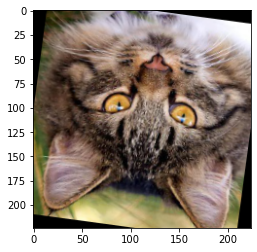

In [25]:
img, label = next(iter(ds_train))
print(img.shape)

# restructure for plt
img = np.transpose(np.array(img), (1,2,0))

# reverse the normalization
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
for i in range(3):
    img[:,:,i] = (img[:,:,i] * std[i]) + mean[i]

plt.imshow(img)
print(label)

## Pretrained Models
- Freezing Layers (feature extraction)
- Finetuning (weight initialization)

In [26]:
# drum roll...the pretrained resnet!
resnet = models.resnet18(pretrained=True)

In [27]:
# we can see the architecture
# note how many of the layers are organized in "BasicBlock"
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- Notice how the image eventually becomes a 1D vector of dimension 512
- In some sense the network has transformed an image into a vector of features helpful for image classification
- The last layer is a simple function (linear followed by softmax) on this feature space that predicts an images class
- One strategy is to train a new simple function on this **same** feature space for our classification task

In [28]:
from torchsummary import summary
summary(resnet, input_size = (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [29]:
# turn off gradients for all the parameters
for param in resnet.parameters():
            param.requires_grad = False

In [30]:
# re-intialize the last layer for our task
print(resnet.fc)
resnet.fc = nn.Linear(512, 3)
print(resnet.fc)

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=3, bias=True)


In [31]:
# re-initializing the layer reset to default settings
for param in resnet.fc.parameters():
    print(param.requires_grad)

True
True


In [32]:
# double-check all the parameters
for name, param in resnet.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

conv1.weight gradient is set to False
bn1.weight gradient is set to False
bn1.bias gradient is set to False
layer1.0.conv1.weight gradient is set to False
layer1.0.bn1.weight gradient is set to False
layer1.0.bn1.bias gradient is set to False
layer1.0.conv2.weight gradient is set to False
layer1.0.bn2.weight gradient is set to False
layer1.0.bn2.bias gradient is set to False
layer1.1.conv1.weight gradient is set to False
layer1.1.bn1.weight gradient is set to False
layer1.1.bn1.bias gradient is set to False
layer1.1.conv2.weight gradient is set to False
layer1.1.bn2.weight gradient is set to False
layer1.1.bn2.bias gradient is set to False
layer2.0.conv1.weight gradient is set to False
layer2.0.bn1.weight gradient is set to False
layer2.0.bn1.bias gradient is set to False
layer2.0.conv2.weight gradient is set to False
layer2.0.bn2.weight gradient is set to False
layer2.0.bn2.bias gradient is set to False
layer2.0.downsample.0.weight gradient is set to False
layer2.0.downsample.1.weight

In [33]:
# pass the appropriate parameters to the optimizer
params_to_update = []

for param in resnet.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
print(params_to_update)

optimizer = optim.Adam(params_to_update, lr=0.001)

[Parameter containing:
tensor([[-0.0035, -0.0438, -0.0002,  ...,  0.0050,  0.0162, -0.0006],
        [-0.0039, -0.0147, -0.0337,  ...,  0.0372, -0.0290, -0.0197],
        [ 0.0019, -0.0031,  0.0114,  ...,  0.0161,  0.0085, -0.0346]],
       requires_grad=True), Parameter containing:
tensor([0.0125, 0.0312, 0.0277], requires_grad=True)]


In [35]:
# let's make sure that this actually freezes/trains the layers, take a sample weight
print(resnet.conv1.weight[0,0])
print(resnet.fc.bias)

tensor([[-0.0104, -0.0061, -0.0018,  0.0748,  0.0566,  0.0171, -0.0127],
        [ 0.0111,  0.0095, -0.1099, -0.2805, -0.2712, -0.1291,  0.0037],
        [-0.0069,  0.0591,  0.2955,  0.5872,  0.5197,  0.2563,  0.0636],
        [ 0.0305, -0.0670, -0.2984, -0.4387, -0.2709, -0.0006,  0.0576],
        [-0.0275,  0.0160,  0.0726, -0.0541, -0.3328, -0.4206, -0.2578],
        [ 0.0306,  0.0410,  0.0628,  0.2390,  0.4138,  0.3936,  0.1661],
        [-0.0137, -0.0037, -0.0241, -0.0659, -0.1507, -0.0822, -0.0058]])
Parameter containing:
tensor([0.0125, 0.0312, 0.0277], requires_grad=True)


In [36]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [37]:
from tqdm.notebook import tqdm

lossFun = nn.CrossEntropyLoss()

num_epochs = 5
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(resnet, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(resnet, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(resnet, dl_train, len(ds_train))
    valid_acc = one_pass_acc(resnet, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/915 [00:00<?, ?it/s]

KeyboardInterrupt: 

Note how long it takes to train for images

In [39]:
print(resnet.conv1.weight[0,0])
print(resnet.fc.bias)

tensor([[-0.0104, -0.0061, -0.0018,  0.0748,  0.0566,  0.0171, -0.0127],
        [ 0.0111,  0.0095, -0.1099, -0.2805, -0.2712, -0.1291,  0.0037],
        [-0.0069,  0.0591,  0.2955,  0.5872,  0.5197,  0.2563,  0.0636],
        [ 0.0305, -0.0670, -0.2984, -0.4387, -0.2709, -0.0006,  0.0576],
        [-0.0275,  0.0160,  0.0726, -0.0541, -0.3328, -0.4206, -0.2578],
        [ 0.0306,  0.0410,  0.0628,  0.2390,  0.4138,  0.3936,  0.1661],
        [-0.0137, -0.0037, -0.0241, -0.0659, -0.1507, -0.0822, -0.0058]])
Parameter containing:
tensor([0.0107, 0.0324, 0.0280], requires_grad=True)


If we want to finetune, we can either
- use the resnet as a starting point and train by treating the pretrained weights as good weight initilaization OR
- we can train different layers at different learning rates (the later the layer, the more we want to adjust the feature)

In [40]:
# we can pass the optimizer groups of parameters rather than all the parameters in one group
for param_group in optimizer.param_groups:
    print(param_group)

{'params': [Parameter containing:
tensor([[-0.0130, -0.0487, -0.0143,  ...,  0.0128,  0.0059,  0.0054],
        [ 0.0077, -0.0053, -0.0204,  ...,  0.0314, -0.0120, -0.0252],
        [-0.0015, -0.0064,  0.0120,  ...,  0.0129, -0.0077, -0.0360]],
       requires_grad=True), Parameter containing:
tensor([0.0107, 0.0324, 0.0280], requires_grad=True)], 'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}


In [41]:
for name, layer in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [43]:
max_lr = 0.01
params = []
for i, layer in enumerate(resnet.children()):
    if i < 6:
        params.append({'params': layer.parameters(), 'lr': max_lr / 100})
    elif 5 < i < 9:
        params.append({'params': layer.parameters(), 'lr': max_lr / 10})
    else:
        params.append({'params': layer.parameters()})
        
print(params)
        
# only the parameters we didn't manually set the learning rate for inherit the learning rate set when defining the optimizer
optimizer = optim.Adam(params, lr = max_lr)

[{'params': <generator object Module.parameters at 0x7fc0e2c57040>, 'lr': 0.0001}, {'params': <generator object Module.parameters at 0x7fc0e2c570b0>, 'lr': 0.0001}, {'params': <generator object Module.parameters at 0x7fc0e2c57120>, 'lr': 0.0001}, {'params': <generator object Module.parameters at 0x7fc0e2c57190>, 'lr': 0.0001}, {'params': <generator object Module.parameters at 0x7fc0e2c57200>, 'lr': 0.0001}, {'params': <generator object Module.parameters at 0x7fc0e2c57270>, 'lr': 0.0001}, {'params': <generator object Module.parameters at 0x7fc0e2c572e0>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7fc0e2c57350>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7fc0e2c573c0>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7fc0e2c57430>}]


In [44]:
# we can see the parameters groups here
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 3
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 4
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 5
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 6
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 7
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 8
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weigh

In [45]:
# to make this a bit cleaner you can make a new model class
# use model.features1, model.features2, and model.classifier to set the learning rates
class Tune_ResNet(nn.Module):
    def __init__(self):
        super(Tune_ResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:9]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Linear(512, 3)
        self.unroll = nn.Flatten()
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.unroll(x)
        x = self.classifier(x)
        return x
    
model = Tune_ResNet()
summary(model, input_size = (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Augmentation for Keypoint Detection

Image Data from [here](https://www.kaggle.com/c/facial-keypoints-detection/data?select=test.zip)
- Facial Keypoints

In [2]:
data_path = 'course_data/facial-keypoints-detection'

train = pd.read_csv(data_path + '/training.csv')
test = pd.read_csv(data_path + '/test.csv')

# keypoint coordinates + image given as string of pixel values (96 x 96)
train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


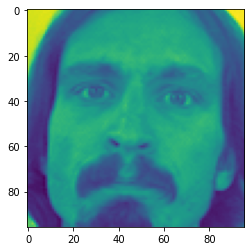

In [3]:
# convert the string into an image
def str_to_img(pixel_str):
    values = np.array([float(ele) for ele in pixel_str.split(' ')])
    img = np.reshape(values, (96, 96))
    return img

plt.imshow(str_to_img(train['Image'][0]))

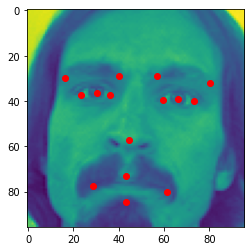

In [4]:
# display the keypoints
def display_keypoints(img, keypoint_list):
    x_values = []
    y_values = []
    # there are fifteen keypoints
    for i in range(15):
        x_values.append(keypoint_list[2*i])
        y_values.append(keypoint_list[2*i+1])
    plt.imshow(img)
    plt.scatter(x=x_values, y=y_values, c='r')

idx = 0
keypoint_list = list(train.iloc[idx][0:30])
img = str_to_img(train['Image'][idx])
    
display_keypoints(img, keypoint_list)

In [5]:
# let's make a simple dataset for our keypoint detection

class FacialKeypointDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = torch.tensor(str_to_img(row['Image'])).float()
        keypoint_values = torch.tensor(row[0:30]).float()
        
        return img, keypoint_values

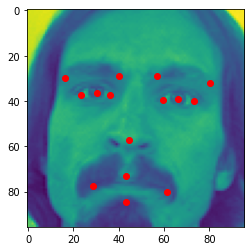

In [6]:
ds_train = FacialKeypointDataset(train)
img, keypoints = next(iter(ds_train))

# looks good!
display_keypoints(np.array(img), list(keypoints))

In [7]:
# but what about augmentation?
class FacialKeypointDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        self.transforms = A.Compose([
                # spatial transforms
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
            ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = str_to_img(row['Image'])
        keypoint_values = torch.tensor(row[0:30]).float()
        
        transformed = self.transforms(image=img.astype(np.uint8))
        img = torch.tensor(transformed['image']).float()
        
        return img, keypoint_values

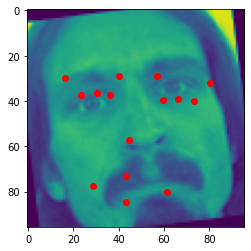

In [8]:
ds_train = FacialKeypointDataset(train)
img, keypoints = next(iter(ds_train))

# not so good now; what happened?
display_keypoints(np.array(img), list(keypoints))

In [9]:
# let's try again, this time passing the keypoints to transformation
class FacialKeypointDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        self.transforms = A.Compose([
                # spatial transforms
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
            ], keypoint_params=A.KeypointParams(format='xy'))
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = str_to_img(row['Image'])
        keypoint_values = row[0:30]
        
        # albumentations takes in a tuple of (x,y) values
        keypoints = []
        for i in range(int(len(keypoint_values) / 2)):
            keypoints.append((keypoint_values[2*i], keypoint_values[2*i+1]))
        
        transformed = self.transforms(image=img.astype(np.uint8), keypoints=keypoints)
        img = torch.tensor(transformed['image']).float()
        keypoints = transformed['keypoints']
        
        keypoint_values = []
        for coord_pair in keypoints:
            keypoint_values.append(coord_pair[0])
            keypoint_values.append(coord_pair[1])
        
        return img, keypoint_values

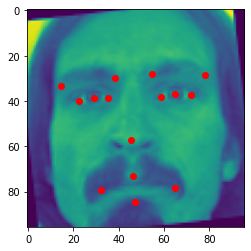

In [17]:
ds_train = FacialKeypointDataset(train)
img, keypoints = next(iter(ds_train))

# looks better now!
display_keypoints(np.array(img), list(keypoints))

Albumentations also handles bounding boxes: [see here](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/)
- difficult issue since usually only boxes along the (x,y) axis are considered!